## Package Import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, l1
from tensorflow.keras.models import load_model
from joblib import dump, load
import matplotlib.pyplot as plt

## Read File

In [2]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]

## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [3]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")

There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [4]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'


## Data Classifier

In [5]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality

## Split dataset into x and y and one-hot encode quality column

In [6]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = new_data['quality']
le = LabelEncoder()
y = le.fit_transform(y)
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(x)
xTrain, xTest, yTrain, yTest = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
scale_xTrain = pd.DataFrame(xTrain)
scale_xTest = pd.DataFrame(xTest)

## NN1

Epoch 1/100
781/781 [==============================] - 3s 3ms/step - loss: 1.2214 - accuracy: 0.4342
Epoch 2/100
781/781 [==============================] - 3s 3ms/step - loss: 1.2010 - accuracy: 0.4461
Epoch 3/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1933 - accuracy: 0.4493
Epoch 4/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1878 - accuracy: 0.4521
Epoch 5/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1831 - accuracy: 0.4513
Epoch 6/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1777 - accuracy: 0.4545
Epoch 7/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1728 - accuracy: 0.4582
Epoch 8/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1675 - accuracy: 0.4635
Epoch 9/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1639 - accuracy: 0.4652
Epoch 10/100
781/781 [==============================] - 2s 3ms/step - loss: 1.1595 - accura

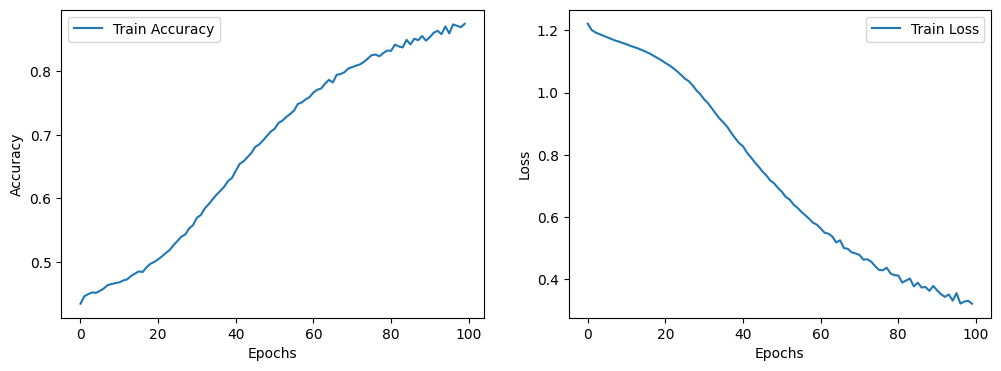

In [33]:
nn1 = Sequential([
    Dense(512, activation='relu', input_dim=scale_xTrain.shape[1]),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax'),
])
nn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = nn1.fit(scale_xTrain, yTrain, epochs=100, batch_size=32)
nn1.save('nn1.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## NN1 analysis

223/223 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      2096
           1       0.65      0.62      0.64      1439
           2       0.64      0.59      0.61       707
           3       0.70      0.75      0.72      2894

    accuracy                           0.69      7136
   macro avg       0.68      0.66      0.67      7136
weighted avg       0.69      0.69      0.69      7136



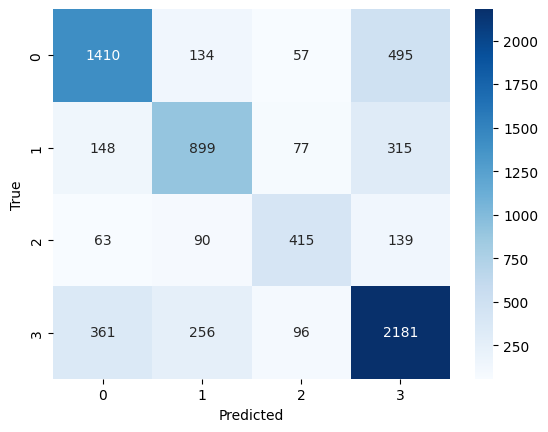

Test Accuracy: 68.73599%
892/892 [==============================] - 1s 1ms/step
Train Accuracy: 68.73599%


In [29]:
import seaborn as sns
nn1 = load_model('nn1.h5')
y_predict = np.argmax(nn1.predict(scale_xTest), axis=1)

print(classification_report(yTest, y_predict))

cf = confusion_matrix(yTest, y_predict)
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
nn1_test_accuracy = accuracy_score(yTest, y_predict)
print(f"Test Accuracy: {nn1_test_accuracy * 100:.5f}%")

y_predict = np.argmax(nn1.predict(scale_xTrain), axis=1)
nn1_train_accuracy = accuracy_score(yTrain, y_predict)
print(f"Train Accuracy: {nn1_test_accuracy * 100:.5f}%")

## NN2

In [ ]:
nn2 = Sequential([
    Dense(512, activation='tanh', input_dim=scale_xTrain.shape[1]),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(4, activation='softmax'),
])
nn2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = nn2.fit(scale_xTrain, yTrain, epochs=100, batch_size=32)
nn2.save('nn2.h5')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## NN2 Analysis

223/223 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      2096
           1       0.54      0.61      0.57      1439
           2       0.59      0.51      0.55       707
           3       0.68      0.67      0.68      2894

    accuracy                           0.64      7136
   macro avg       0.63      0.62      0.62      7136
weighted avg       0.65      0.64      0.64      7136



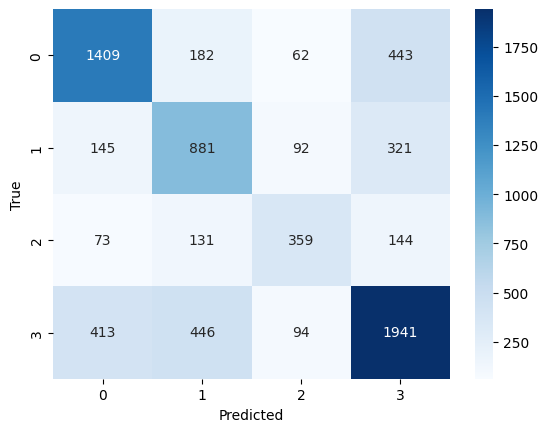

Test Accuracy: 64.32175%
892/892 [==============================] - 1s 1ms/step
Train Accuracy: 65.26994%


In [28]:
nn2 = load_model('nn2.h5')
y_predict = np.argmax(nn2.predict(scale_xTest), axis=1)

print(classification_report(yTest, y_predict))

cf = confusion_matrix(yTest, y_predict)
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
nn2_test_accuracy = accuracy_score(yTest, y_predict)
print(f"Test Accuracy: {nn2_test_accuracy * 100:.5f}%")

y_predict = np.argmax(nn2.predict(scale_xTrain), axis=1)
nn2_train_accuracy = accuracy_score(yTrain, y_predict)
print(f"Train Accuracy: {nn2_train_accuracy * 100:.5f}%")

## Random Forest

In [59]:
RF_model = RandomForestClassifier(n_estimators=1000)
RF_model.fit(scale_xTrain, yTrain)
dump(RF_model, 'RF.joblib')

['RF.joblib']

## RF Analysis

In [27]:
RF_model = load('RF.joblib')
y_pred = RF_model.predict(scale_xTest)
print("Classification Report:")
print(classification_report(yTest, y_pred))
rf_test_accuracy = accuracy_score(yTest, y_pred)
print(f"Test Accuracy: {rf_test_accuracy * 100:.5f}%")

y_pred = RF_model.predict(scale_xTrain)
rf_train_accuracy = accuracy_score(yTrain, y_pred)
print(f"Train Accuracy: {rf_train_accuracy * 100:.5f}%")

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2096
           1       0.97      0.69      0.81      1439
           2       0.98      0.61      0.75       707
           3       0.76      0.94      0.84      2894

    accuracy                           0.83      7136
   macro avg       0.89      0.77      0.81      7136
weighted avg       0.85      0.83      0.83      7136

Test Accuracy: 82.95964%
Train Accuracy: 83.40048%


## Ensemble model

In [30]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Get predictions for each model on the training and test set
nn1_preds_train = nn1.predict(scale_xTrain)
nn2_preds_train = nn2.predict(scale_xTrain)
rf_preds_train = RF_model.predict_proba(scale_xTrain)

nn1_preds_test = nn1.predict(scale_xTest)
nn2_preds_test = nn2.predict(scale_xTest)
rf_preds_test = RF_model.predict_proba(scale_xTest)

# Classification report on test set to get the precisions for weighting
report_nn1_test = classification_report(yTest, np.argmax(nn1.predict(scale_xTest), axis=1), output_dict=True)
report_nn2_test = classification_report(yTest, np.argmax(nn2.predict(scale_xTest), axis=1), output_dict=True)
report_rf_test = classification_report(yTest, RF_model.predict(scale_xTest), output_dict=True)

# Get precisions for each class on the test set
precisions_nn1_test = np.array([report_nn1_test[str(i)]['precision'] for i in range(4)])
precisions_nn2_test = np.array([report_nn2_test[str(i)]['precision'] for i in range(4)])
precisions_rf_test = np.array([report_rf_test[str(i)]['precision'] for i in range(4)])

# Use test set precisions to weight each model's predictions on both the training and test sets
nn1_preds_train *= precisions_nn1_test.reshape(1, -1)
nn2_preds_train *= precisions_nn2_test.reshape(1, -1)
rf_preds_train *= precisions_rf_test.reshape(1, -1)

nn1_preds_test *= precisions_nn1_test.reshape(1, -1)
nn2_preds_test *= precisions_nn2_test.reshape(1, -1)
rf_preds_test *= precisions_rf_test.reshape(1, -1)

# Compute the ensemble predictions for both the training and test sets
ensemble_preds_train = (nn1_preds_train + nn2_preds_train + rf_preds_train) / 3
ensemble_preds_test = (nn1_preds_test + nn2_preds_test + rf_preds_test) / 3

# Get results for both the training and test sets
ensemble_preds_train = np.argmax(ensemble_preds_train, axis=1)
ensemble_preds_test = np.argmax(ensemble_preds_test, axis=1)

# Calculate the ensemble model accuracy on both the training and testing sets
ensemble_train_accuracy = accuracy_score(yTrain, ensemble_preds_train)
ensemble_test_accuracy = accuracy_score(yTest, ensemble_preds_test)

# Print the ensemble model accuracies
print(f"Ensemble training accuracy: {ensemble_train_accuracy:.5f}")
print(f"Ensemble test accuracy: {ensemble_test_accuracy:.5f}")



223/223 [==============================] - 0s 1ms/step
Ensemble training accuracy: 0.77784
Ensemble test accuracy: 0.77088


## Pictures

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      8303
           1       0.78      0.71      0.74      5706
           2       0.84      0.63      0.72      2886
           3       0.76      0.83      0.80     11648

    accuracy                           0.78     28543
   macro avg       0.79      0.74      0.76     28543
weighted avg       0.78      0.78      0.78     28543

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2096
           1       0.78      0.70      0.74      1439
           2       0.84      0.63      0.72       707
           3       0.76      0.83      0.79      2894

    accuracy                           0.77      7136
   macro avg       0.79      0.74      0.76      7136
weighted avg       0.77      0.77      0.77      7136



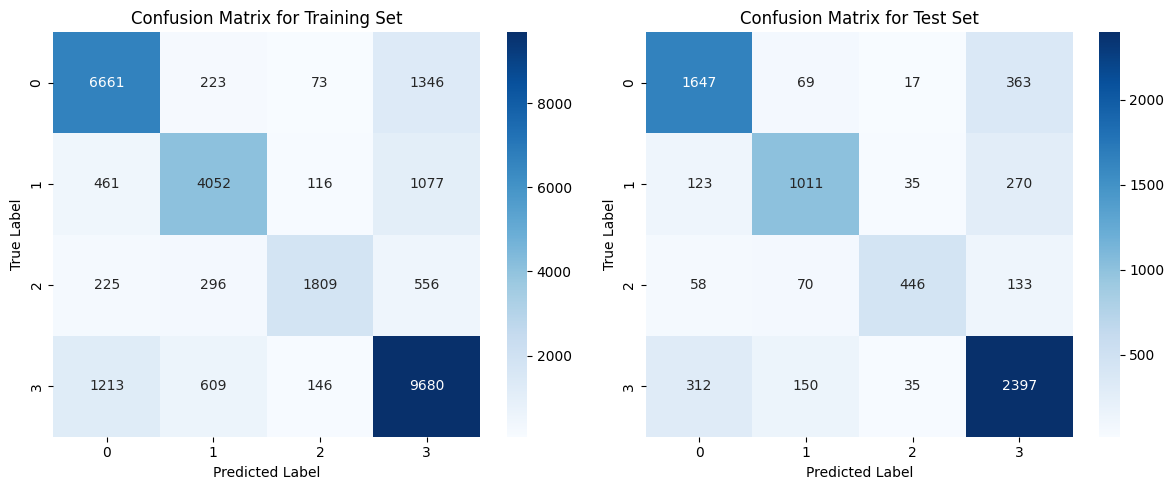

In [31]:

print("Classification Report for Training Set:")
print(classification_report(yTrain, ensemble_preds_train))

print("Classification Report for Test Set:")
print(classification_report(yTest, ensemble_preds_test))


confusion_matrix_train = confusion_matrix(yTrain, ensemble_preds_train)
confusion_matrix_test = confusion_matrix(yTest, ensemble_preds_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix_train, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()